<a href="https://colab.research.google.com/github/arafaelll/Analista-de-Dados---Pipeline-de-Dados-do-Telegram/blob/main/Analista_de_Dados_Pipeline_de_Dados_do_Telegram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto final EBAC Analista de Dados - Pipeline de Dados do Telegram**

#**Objetivo**

O objetivo deste projeto é implementar um pipeline de dados do Telegram utilizando serviços da AWS para demonstrar o ciclo completo de ingestão, processamento, armazenamento e análise de dados oriundos de interações em um grupo da plataforma.

Com esse pipeline, pretende-se demonstrar uma arquitetura escalável e replicável para projetos que envolvam captura de dados em tempo real em plataformas de mensageria e sua integração com ferramentas de análise em nuvem.

# **Introdução**

O uso de bots em plataformas de mensagens instantâneas tem se tornado uma solução cada vez mais relevante para automação de processos e interação com usuários. O Telegram, por ser uma ferramenta aberta e pioneira no suporte à criação de bots, oferece uma API robusta que permite capturar e processar diferentes tipos de mensagens enviadas em grupos, como textos, imagens, arquivos, áudios e vídeos.

Neste projeto, foi desenvolvido um pipeline de dados do Telegram que integra desde a coleta das mensagens em um grupo até a disponibilização de informações estruturadas para análise. O processo é dividido em três etapas principais:

* Ingestão: as mensagens enviadas no grupo do Telegram são capturadas por um bot,
encaminhadas para uma API criada no AWS API Gateway e processadas por uma função AWS Lambda, que armazena os dados crus em formato JSON em um bucket do AWS S3.

* ETL (Extract, Transform, Load): diariamente, uma nova função AWS Lambda é acionada pelo AWS Event Bridge para processar os dados crus do dia anterior (D-1). Nessa etapa, os dados são transformados e salvos em formato Parquet, enriquecidos e particionados, garantindo melhor performance em consultas analíticas.

* Apresentação: por fim, os dados enriquecidos são disponibilizados em uma tabela no AWS Athena, permitindo que consultas SQL sejam realizadas para explorar o comportamento dos usuários, identificar padrões de interação e gerar insights a partir do uso do bot no Telegram.

Com essa arquitetura, o pipeline viabiliza a transformação de mensagens não estruturadas em informações organizadas e de fácil acesso, possibilitando análises exploratórias e contribuindo para estudos de comportamento digital, além de servir como modelo de integração entre aplicações de mensageria e serviços em nuvem da AWS.

# **Bibliotecas**

In [1]:
import os
import json
import requests
import logging
from datetime import datetime, timedelta, timezone
from getpass import getpass

import boto3
import pyarrow as pa
import pyarrow.parquet as pq

## 1\. Telegram.

1.1. Crie uma conta no **Telegram** caso não possua uma e faça o login na versão web da ferramenta através desse [link](https://web.telegram.org).

1.2. Crie um *bot*.

1.3. Crie um grupo e adicione o *bot*.

1.4. Torne o *bot* administrador do grupo.

1.5. Desabilite a opção de adicionar o *bot* a novos grupos.

1.6. Envie diversos tipos de mensagens no grupo (text, imagem, arquivos, video, áudio, etc.) e as consuma utilizand a API de *bots* do **Telegram**.

> **Nota:** A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api)

In [ ]:
# inserir o token do bot

from getpass import getpass

token = getpass()

··········


In [ ]:
# url para API

base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
# vamos usar o getMe para retornar informações sobre o bot para conferência

response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot8377982247:AAENS5H87psQfiHfl4b2VhlEcn2OqVf5grI/getMe
{
  "ok": true,
  "result": {
    "id": 8377982247,
    "is_bot": true,
    "first_name": "m43_ebac_bot_telegram_rafael_bot",
    "username": "m43_ebac_bot_telegram_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


## 2\. Ingestão de dados crus.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus.

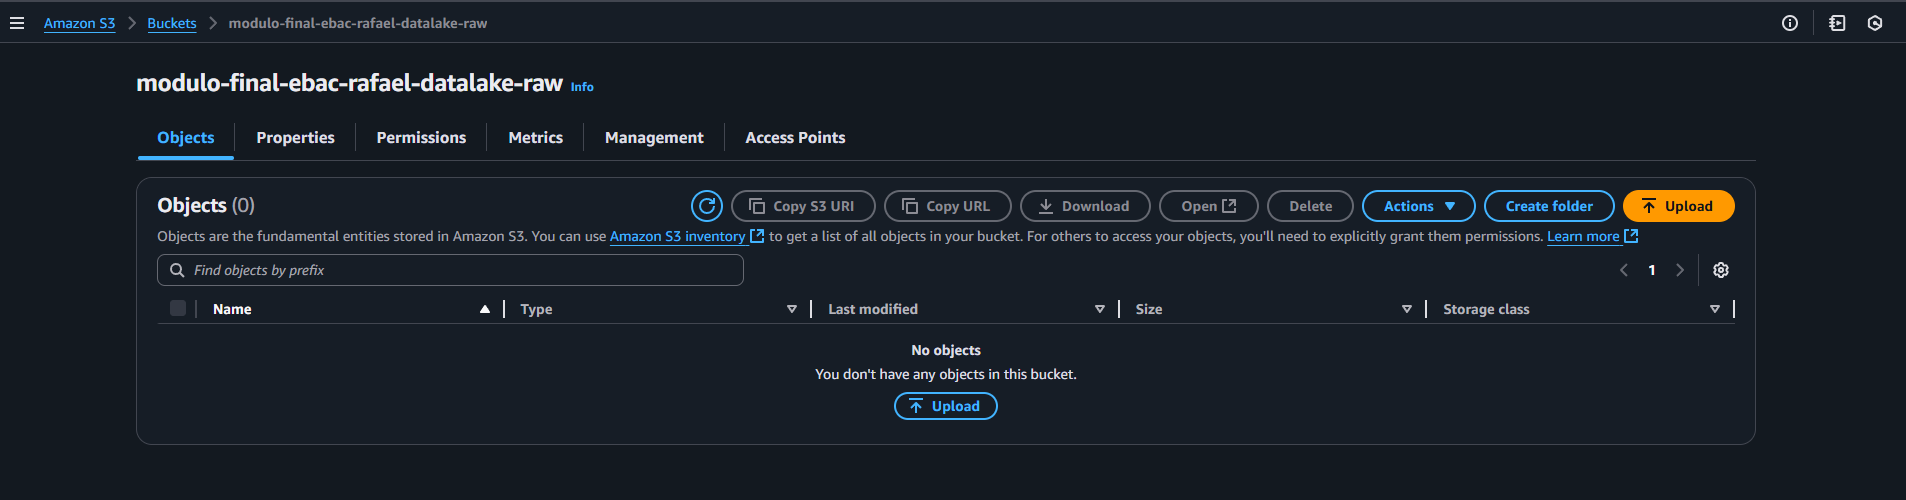

2.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. E configurar as variáveis de ambiente, adicionar a permissão de interação com `AWS S3` no `AWS IAM`.

2.2.1. Código da função lambda.

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

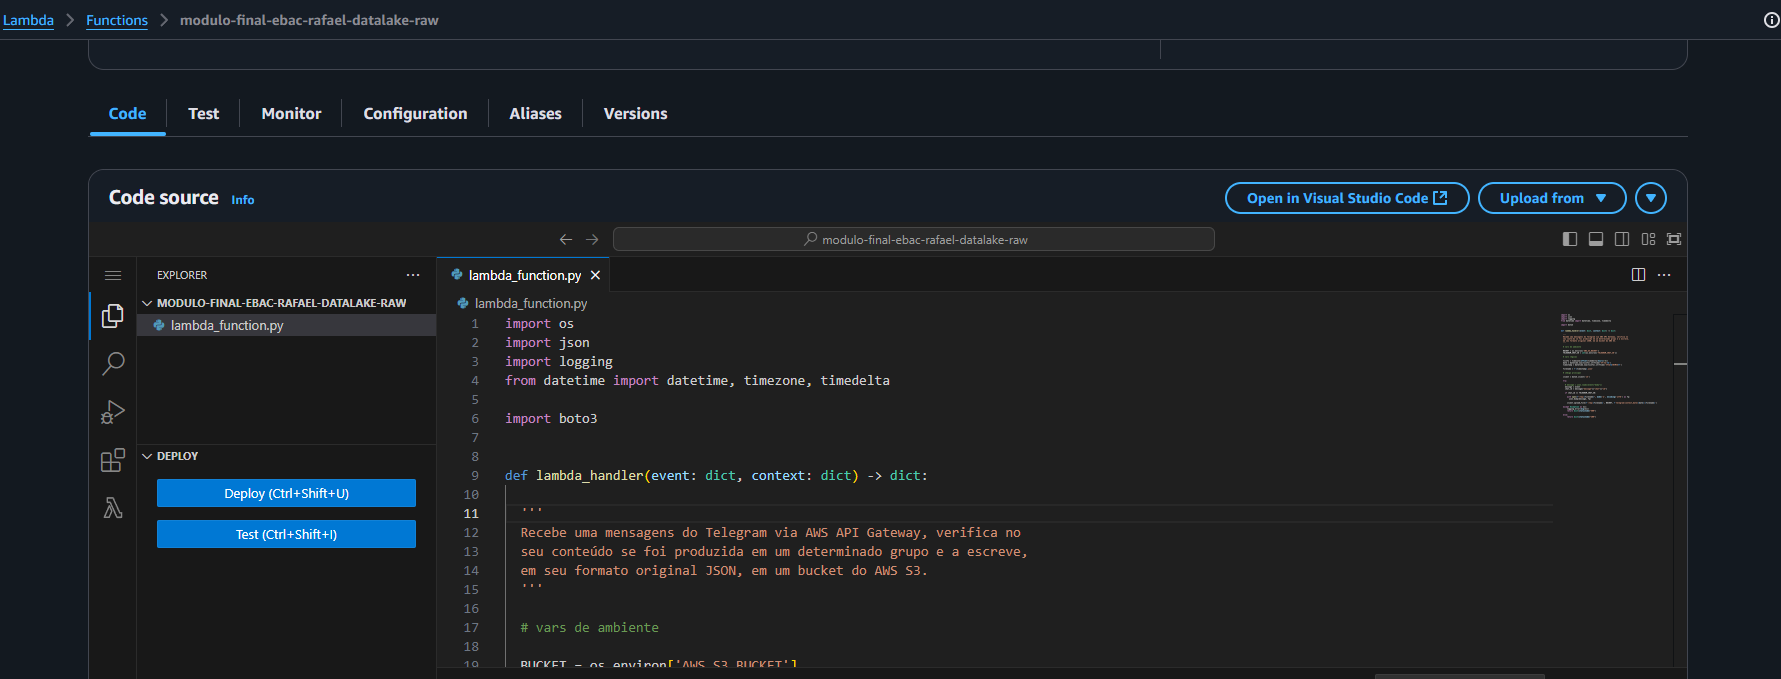

2.2.2. Configure as variáveis de ambiente.

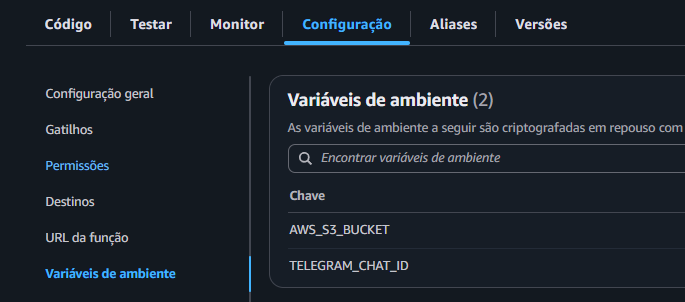

2.2.3. Adicionar permissão para que a função lambda tenha acesso ao bucket.

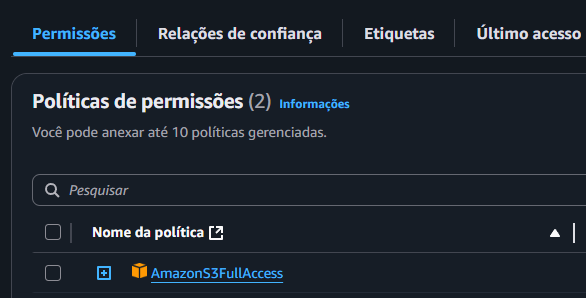

> **Nota**: É recomendado dar acesso apenas aos buckets utilizados.

2.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`.

 - Acesse o serviço e selecione: *Create API* -> *REST API*;
 - Insira um nome, como padrão, um que termine com o sufixo `-api`;
 - Selecione: *Actions* -> *Create Method* -> *POST*;
 - Na tela de *setup*:
  - Selecione *Integration type* igual a *Lambda Function*;
  - Habilite o *Use Lambda Proxy integration*;
  - Busque pelo nome a função do `AWS Lambda`.


2.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

In [ ]:
from getpass import getpass

aws_api_gateway_url = getpass()

··········


In [ ]:
base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


## 3\. ETL

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

3.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos.

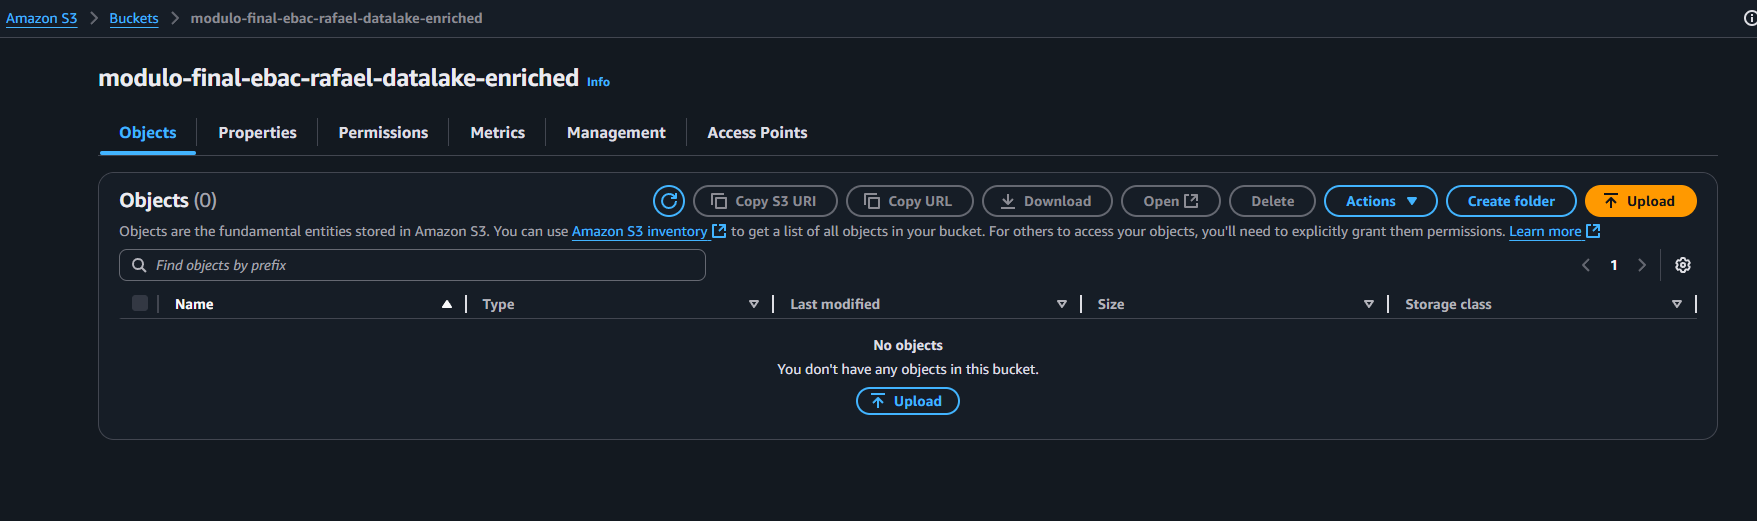

3.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

3.2.1. Código da função lambda.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

3.2.2. Configurar as variáveis de ambiente.

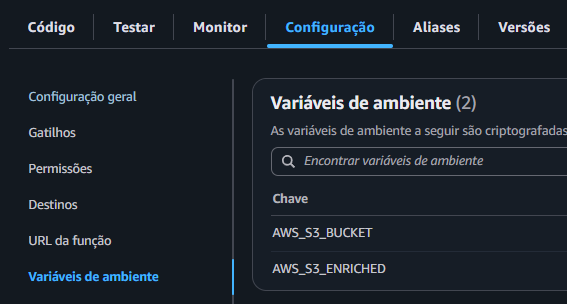

3.2.3. Adicionar permissão para que a função lambda tenha acesso ao bucket.

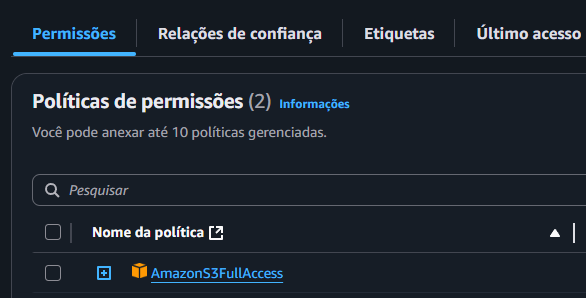

> **Nota**: É recomendado dar acesso apenas aos buckets utilizados.

3.2.3. Configurar o timeout em 5 minutos para dar tempo de realizar todo processo.

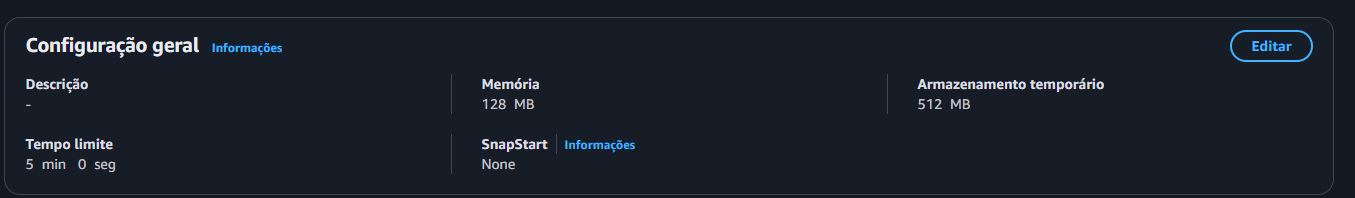

3.2.4. Adicionar a layer com o código do pacote Python PyArrow.

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`. Vamos então seguir com a última opção, onde teremos que:

 - Criar um *bucket* no `AWS S3`;
 - Fazer o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criar *layer* e conectar na função.

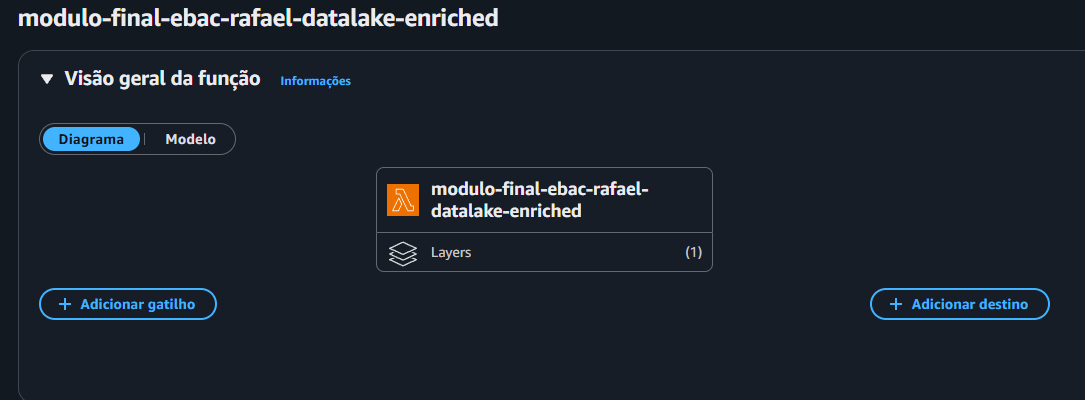

3.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

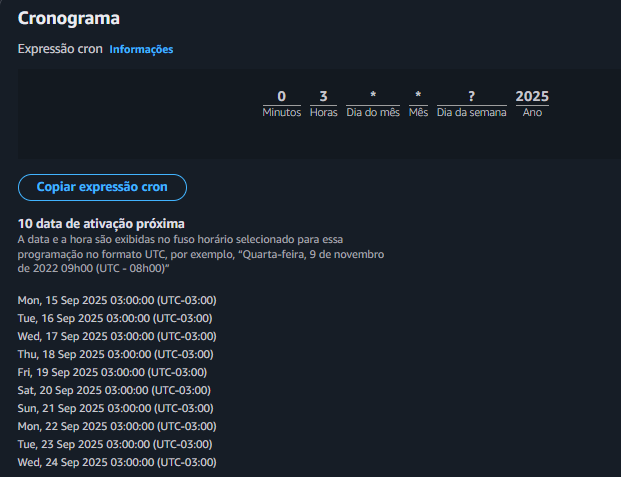

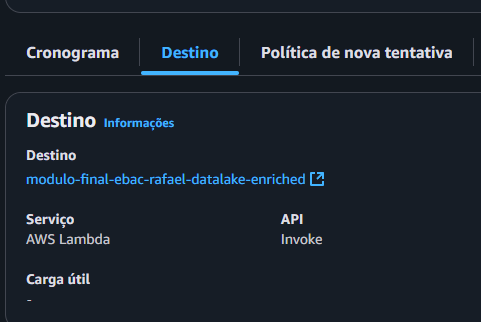

## 4\. Apresentação

4.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

Código da tabela.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

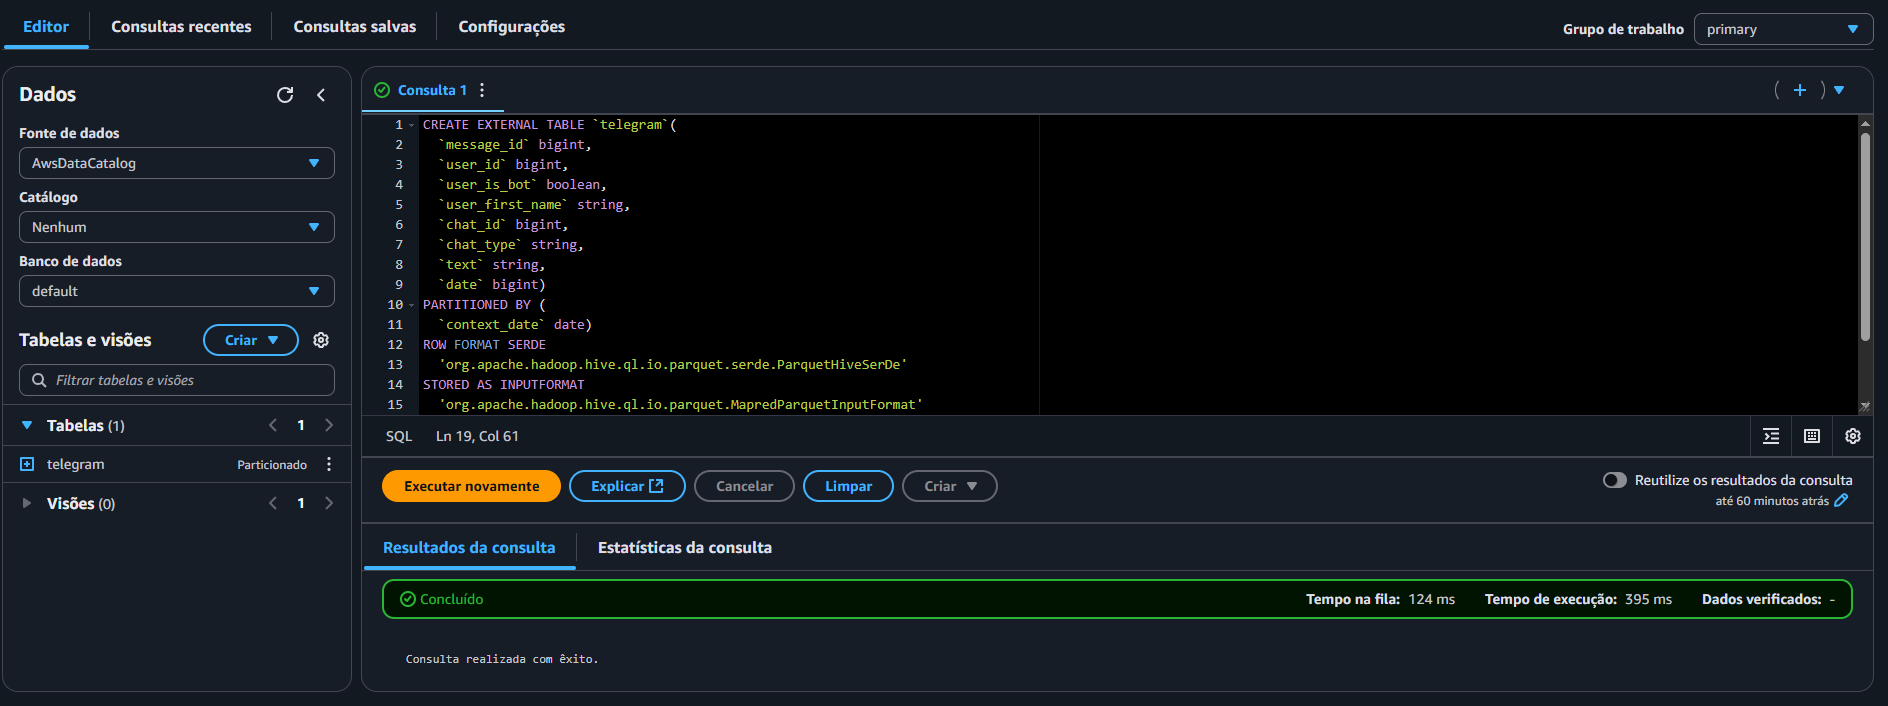

4.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

```sql
MSCK REPAIR TABLE `telegram`;
```

## 5\. Consulta de dados

5.1. Vizualizar as 10 primeiras linhas.

```sql
SELECT * FROM telegram LIMIT 10;
```

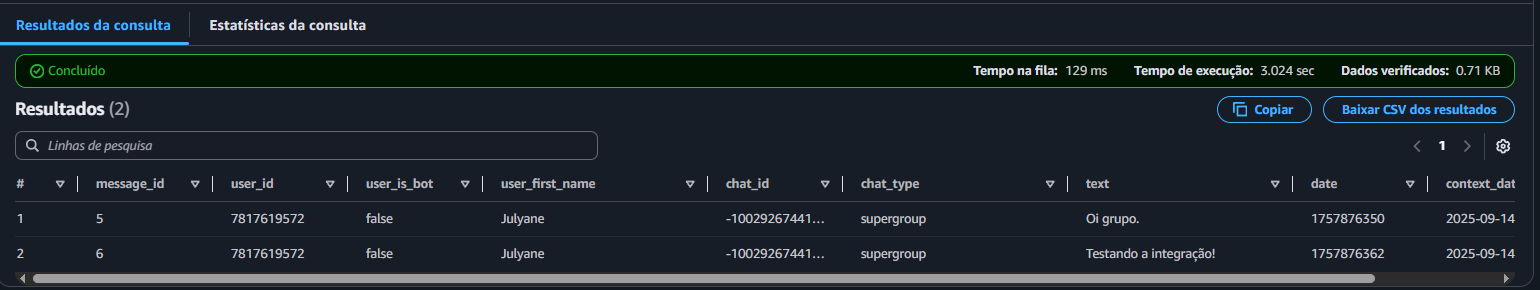

5.2. Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

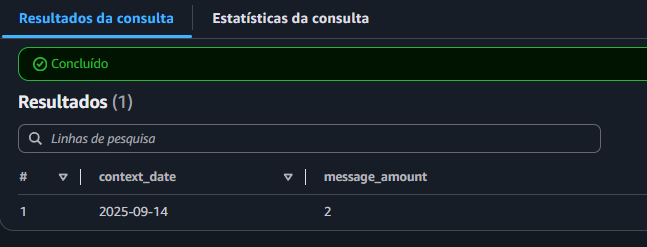

5.3. Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

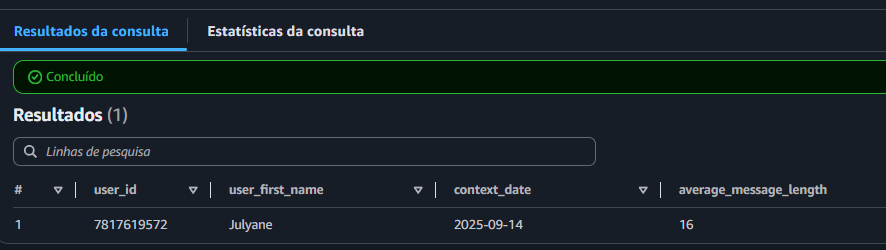